# Analysis of Rolling Sales Data - Bronx (04/01/2020 - 03/31/2021)

# Steps

I am going to do the following:

    1. Import necessary modules
    2. Load the prepped data per borough 
    3. Analyze the data for trends and seasonality
    4. Dickey-Fuller Tests and preparing data for ARMA modeling
        - Induce stationarity if needed
    5. ARMA model of the data
    6. Error analysis of the ARMA model
        - Try to improve ARMA model
    7. Comparison with latest data
        -Test data from 04/01/2021 - 04/31/2021
    8. Observations/Conclusions/Recommendations

## 1. Imports

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import datetime
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn
import math

#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Loading the prepared data

##### Observations: 
 - Once I loaded the data and sorted it, the SALE DATE values range from 4/1/2020 until 3/31/2021.
 - This data was the most recent data when I started working on the project. 
 - NYC OpenData website updates this data regularly with newer months about every 2-3 months
 - The latest data which came out this month gave data up to 4/31/2021, which I can test against the prediction for 30 days

In [2]:
#Loading prepped data
df = pd.read_csv('rollingsales_bronx.xls_prepped_bare.csv')
df.reset_index(drop=True, inplace=True)
df.sort_values('SALE DATE')

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
1217,4,10474,5350000,2020-04-01
2213,1,10469,575000,2020-04-01
2377,1,10471,2118000,2020-04-01
486,1,10458,650000,2020-04-01
2126,2,10462,270000,2020-04-01
...,...,...,...,...
235,1,10469,900000,2021-03-31
2005,2,10462,115000,2021-03-31
3666,1,10462,870000,2021-03-31
2188,1,10467,580000,2021-03-31


## 3. Analyzing the data for trends/seasonality

I do the following steps here to help the data work with the modules:

    1. Convert 'SALE DATE' column to datetime format
    2. Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column
    3. Since we have multiple sales per day, I will aggregate the data into daily data by taking the daily average of sales
    4. Check the data for any nulls/NaNs
        -Decide what to do for Nulls/NaNs
    5. Use statsmodels to observe the data for trends and seasonality
    
##### Observations:
    - NaN values came into the data after the data got aggregated. 
    - Upon further inspection, this was due to the 70 days of no sales in the origional data. 
        - Dropping these rows will result in skewing the data predictions
        - I decided to repalce the NaN values with 0 since no sales were done on that day
            -This also preserves the 365 day row length

In [3]:
# 1. Convert 'SALE DATE' column to datetime format

df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

In [4]:
# 2 . Create new dataframe with 'SALE DATE' as the index and 'SALE PRICE' as the column

df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])
df_price_date = df_price_date.set_index('SALE DATE')
df_price_date.head()

,SALE PRICE
SALE DATE,
2021-01-15,600000
2020-07-23,475000
2020-08-25,289000
2020-09-22,526000
2020-04-22,734000


In [5]:
# 3. Group the sales data by daily average

df_price_date = df_price_date.resample('D').mean()

In [7]:
# 4. We see here number of rows went down from 3982 to 265. Why wasn't it 365 rows to represent all days of the year?
df_price_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-04-01 to 2021-03-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SALE PRICE  265 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [8]:
#Here we see that since we resampled by day, there are NaN values for the days that there were no sales due to no sale date, pandas autofilled it with NaN
df_price_date['SALE PRICE'].isna().sum()

100

In [9]:
# 4. Instead of dropping the rows, I decided to fill NaN with 0 to reflect no sales for the day
df_price_date['SALE PRICE'].fillna(0, inplace=True)
df_price_date

,SALE PRICE
SALE DATE,
2020-04-01,1.234333e+06
2020-04-02,5.502250e+05
2020-04-03,6.185000e+05
2020-04-04,0.000000e+00
2020-04-05,0.000000e+00
...,...
2021-03-27,0.000000e+00
2021-03-28,0.000000e+00
2021-03-29,4.119000e+05


In [10]:
# 5. Checking for trends/seasonality
#Here I check the origional data against its 7-day weekly rolling window to see if theres any discernable pattern

df_price_date['roll_avg'] = df_price_date.rolling(window=7).mean()
df_price_date

,SALE PRICE,roll_avg
SALE DATE,,
2020-04-01,1.234333e+06,NaN
2020-04-02,5.502250e+05,NaN
2020-04-03,6.185000e+05,NaN
2020-04-04,0.000000e+00,NaN
2020-04-05,0.000000e+00,NaN
...,...,...
2021-03-27,0.000000e+00,623653.959184
2021-03-28,0.000000e+00,559368.244898
2021-03-29,4.119000e+05,521883.319728


Text(0, 0.5, 'Average Price')

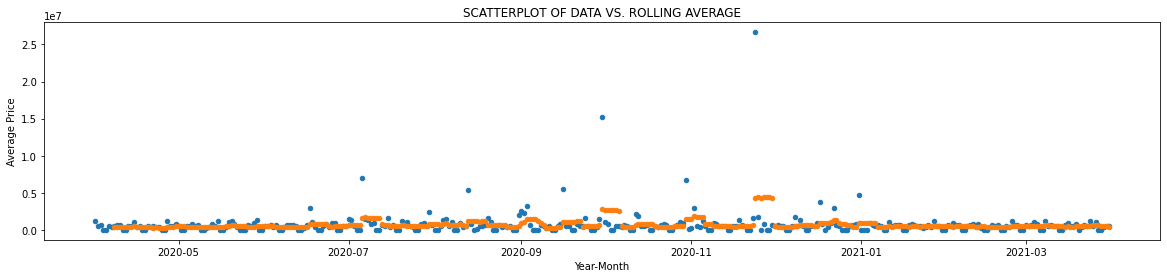

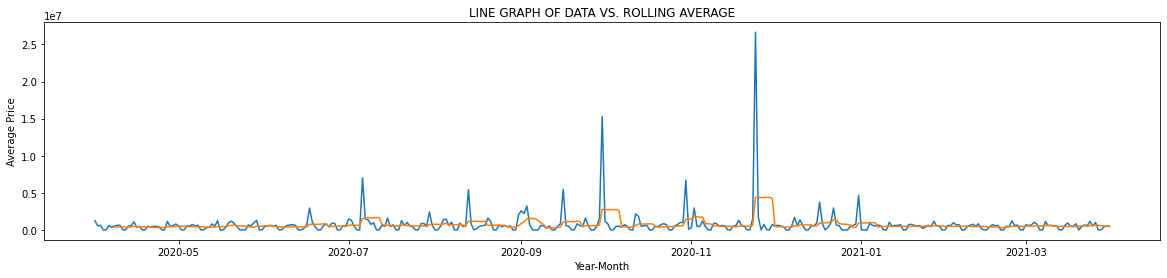

In [11]:
#Plotting the 7-day rolling average against the origional data

plt.figure(figsize=(20, 4))
plt.title("SCATTERPLOT OF DATA VS. ROLLING AVERAGE")
plt.xlabel("Year-Month")
plt.ylabel("Average Price")

#s=20 to keep dots small in size
plt.scatter(df_price_date.index[:365], df_price_date['SALE PRICE'][:365], s=20)
plt.scatter(df_price_date.index[7:], df_price_date['roll_avg'][7:], s=20);
plt.figure(figsize=(20, 4))

plt.title("LINE GRAPH OF DATA VS. ROLLING AVERAGE")
plt.plot(df_price_date.index[:365], df_price_date['SALE PRICE'][:365])
plt.plot(df_price_date.index[7:], df_price_date['roll_avg'][7:]);
plt.xlabel("Year-Month")
plt.ylabel("Average Price")

##### Observation

    - The spikes in the data where the price goes to the millions or tens of millions is due to buildings being bought.
    - Other than that, the rest are residential properties well under a million in price

In [12]:
# Statsmodels decomposition 

# Additive model was chosen here. It would not allow multiplicative with "0" values in the rows.
# Period of 7 for weekly lag

decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='additive', period=7)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [13]:
register_matplotlib_converters()

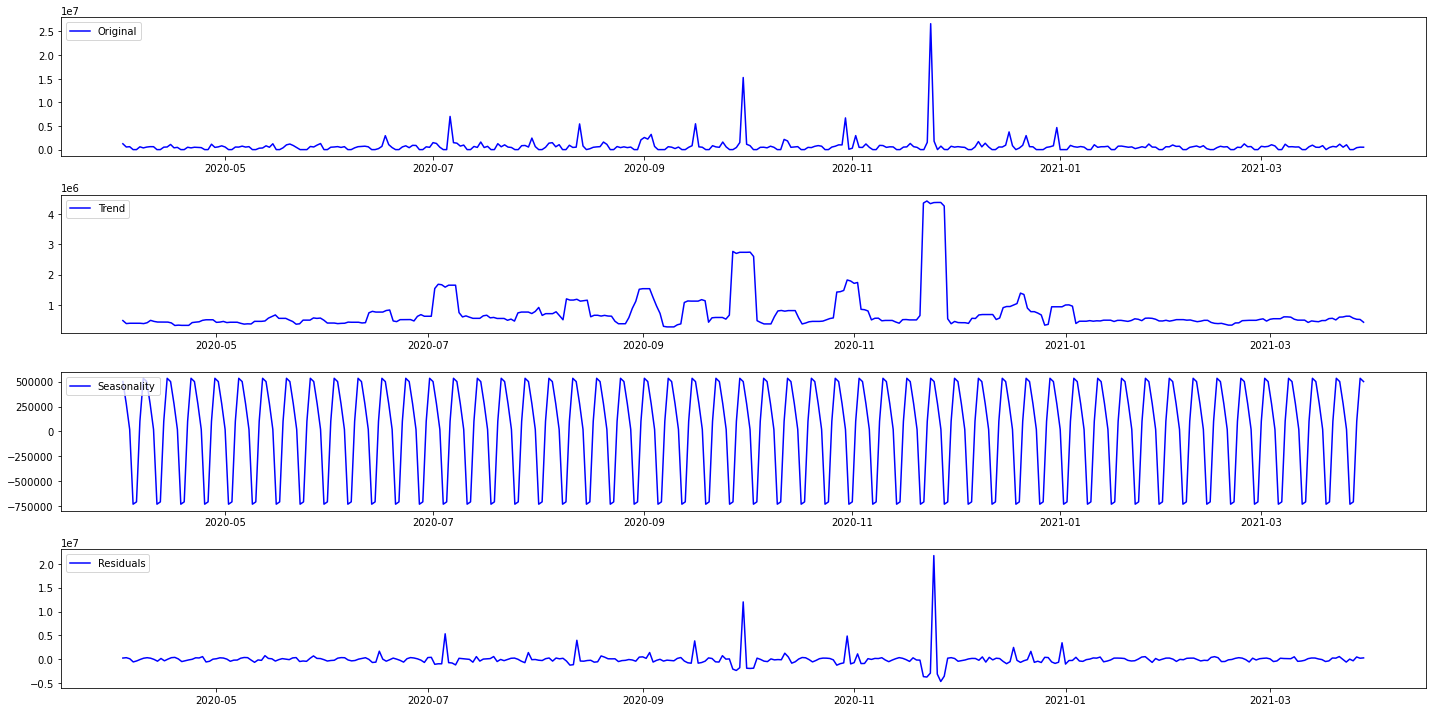

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

##### Observations: 
 - Looks like there may be some seasonality every month

## 4. Dickey-Fuller Tests and preparing data for ARMA modeling

    1. First I will run initial Augmented Dickey Fuller (ADF) test to check if the data is already stationary and does not have a unit root.
    2. If the data fails the ADF test, I will induce stationarity using the following methods:
        - Differencing
        - Logging the data
        - Rolling mean subtraction
    

In [15]:
# Initial test
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-17.412873087453534, 4.874614202176964e-30, 0, 364, {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}, 10985.016277772373)

Test Statistic                -1.741287e+01
p-value                        4.874614e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


### Augmented Dickey Fuller Test Goals: 

Our goal is to induce stationarity and show that the data does not have a unit root. 

ADF Test Null Hypothesis: The data has a unit root and is non-stationary.

Requirements for stationarity:

    1. If p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
        - If p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    2. If the Test Statistic is lower than the critical values, then reject the null hypothesis. Data does not have a unity root and is stationary


### Results of ADF Test

<b><u>Test Statistic vs. Critical Values</b></u>
- Initial test shows Test Statistic of **-17.41287**, this is greater than the critical values for 1% and 5%.
    - <i>We **REJECT** the null hypothesis! The data does not have a unit root and is stationary</i>

<b><u>P-Value Analysis</b></u>


- Our current p-value is **4.874614e-30** which is REALLY close to zero.
    - <i>This means: p-value <= 0.05: </i>
    - <i>We **REJECT** the null hypothesis! The data does not have a unit root and is stationary</i>

## 5. ARMA MODELING

Because ADF test shows data was stationary and does not have a unit root, we can proceed with ARMA model setup.

ACF and PACF will be used to determine the parameters. 

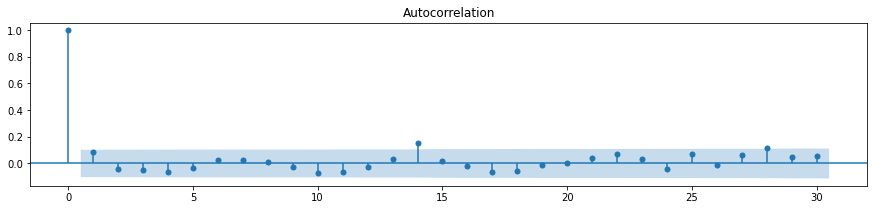

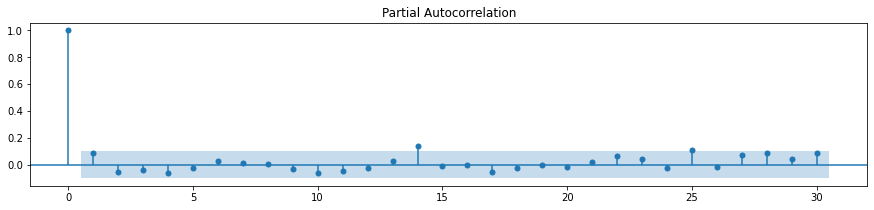

In [18]:
# ACF AND PACF

rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date['SALE PRICE'], lags=30, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date['SALE PRICE'], lags=30, alpha=0.05);

In [19]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
p = 4

# q = lagged forecast errors - PACF
q = 4

#d = number of differences - will compare differenced data RMSE with this model to see if that is better prediction
# d=


# Fitting ARMA model and summary
ar = ARMA(df_price_date['SALE PRICE'],(p,q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  365
Model:                     ARMA(4, 4)   Log Likelihood               -5756.910
Method:                       css-mle   S.D. of innovations        1694172.840
Date:                Sun, 20 Jun 2021   AIC                          11533.821
Time:                        14:58:33   BIC                          11572.820
Sample:                    04-01-2020   HQIC                         11549.319
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.362e+05   8.98e+04      8.199      0.000     5.6e+05    9.12e+05
ar.L1.SALE PRICE     0.2301      0.024      9.640      0.000       0.183       0.277
ar.L2.SALE PRICE    -0.7008      0.016    -43.554      0.000      -0.732      -0.669
ar.L3.SALE PRICE     0.1941        nan        nan        nan         nan         nan
ar.L4.SALE PRICE    -0.9708        nan        nan        nan         nan         nan
ma.L1.SALE PRICE    -0.2115      0.026     -8.027      0.000      -0.263      -0.160
ma.L2.SALE PRICE     0.6979      0.023     30.422      0.000       0.653       0.743
ma.L3.SALE PRICE    -0.2115      0.028     -7.645      0.000      -0.266      -0.157
ma.L4.SALE PRICE     1.0000      0.033     30.434      0.000       0.936       1.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6240           -0.7815j            1.0001           -0.1428
AR.2            0.6240           +0.7815j            1.0001            0.1428
AR.3           -0.5241           -0.8690j            1.0148           -0.3364
AR.4           -0.5241           +0.8690j            1.0148            0.3364
MA.1           -0.5201           -0.8541j            1.0000           -0.3371
MA.2           -0.5201           +0.8541j            1.0000            0.3371
MA.3            0.6259           -0.7799j            1.0000           -0.1424
MA.4            0.6259           +0.7799j            1.0000            0.1424
-----------------------------------------------------------------------------
"""

<Figure size 1440x720 with 0 Axes>

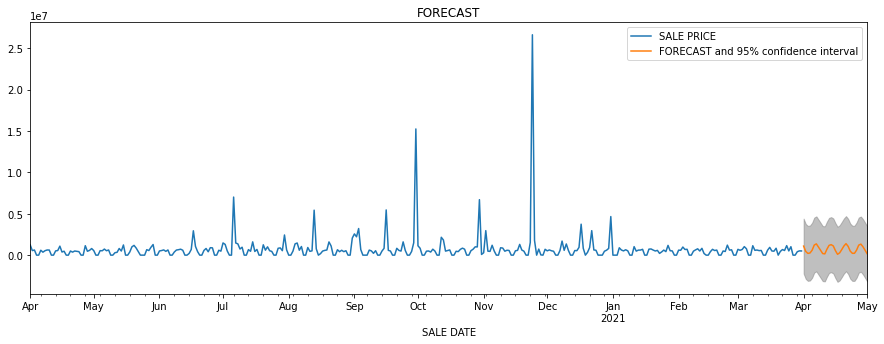

In [20]:
#plot of ARMA model
plt.figure(figsize=(20,10))
fig, ax = plt.subplots()
# ax = df_price_date['SALE_PRICE_LOGGED'].plot(ax=ax, title='FORECAST')
ax = df_price_date['SALE PRICE'].plot(ax=ax, title='FORECAST',figsize=(15,5))
fig = ar.plot_predict(365, 395, dynamic=True, ax=ax, plot_insample=True)

handles, labels = ax.get_legend_handles_labels()
labels = ['SALE PRICE', 'FORECAST and 95% confidence interval']
ax.legend(handles, labels)

plt.show()

## 6. Error analysis of ARMA model

Length of Predictions :  90
Length of Test data :  90
RMSE :  539617.4473756085
Standard Error :  89789.23592683914


Text(0, 0.5, 'Average Price (in hundreds of thousands)')

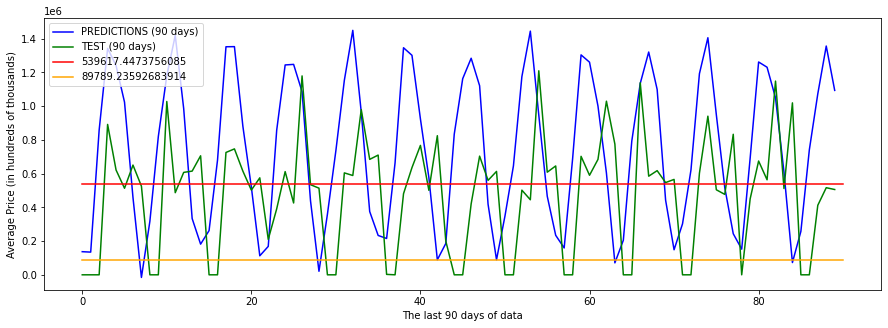

In [21]:
predictions = list(ar.predict(276, 365))
test = list(df_price_date['SALE PRICE'][275:365])

print("\033[1m" + '\033[4m'+ 'Length of Predictions' + "\033[0m", ': ', len(predictions))
print("\033[1m" + '\033[4m'+ 'Length of Test data' + "\033[0m", ': ', len(test))

#RMSE
mse = sklearn.metrics.mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
print("\033[1m" + '\033[4m'+ 'RMSE' + "\033[0m", ': ', rmse)

#standard error
stderr = ar.bse.const
print("\033[1m" + '\033[4m'+ 'Standard Error' + "\033[0m", ': ', stderr)

#plot of all
plt.figure(figsize=(15,5))
plt.plot(predictions, label='PREDICTIONS (90 days)', color='blue')
plt.plot(test, label='TEST (90 days)', color='green')

x=[0,90]
y=[rmse,rmse]
plt.plot(x,y, label=rmse, color='red')

x=[0,90]
y=[stderr,stderr]

plt.plot(x,y, label=stderr, color='orange')

plt.legend(loc='best')
plt.xlabel("The last 90 days of data")
plt.ylabel("Average Price (in hundreds of thousands)")

##### Observation:

RMSE is not too high and not too low compared to the data. Does not indicate a bad fit nor a good fit
- RMSE is 539617.4
- Standard error is 89789.2

## 6a. Testing parameters to improve ARMA model

- I will try p of 7 per ACF
- I will try q of 7 per PACF
- I will try d = 7 to difference weekly

In [22]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
p = 10

# q = lagged forecast errors - PACF
q = 10

#d = number of differences 
d = 7


# Fitting ARMA model and summary
ar1 = ARMA(df_price_date['SALE PRICE'],(p,d,q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  365
Model:                     ARMA(4, 4)   Log Likelihood               -5756.910
Method:                       css-mle   S.D. of innovations        1694172.840
Date:                Sun, 20 Jun 2021   AIC                          11533.821
Time:                        15:00:42   BIC                          11572.820
Sample:                    04-01-2020   HQIC                         11549.319
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.362e+05   8.98e+04      8.199      0.000     5.6e+05    9.12e+05
ar.L1.SALE PRICE     0.2301      0.024      9.640      0.000       0.183       0.277
ar.L2.SALE PRICE    -0.7008      0.016    -43.554      0.000      -0.732      -0.669
ar.L3.SALE PRICE     0.1941        nan        nan        nan         nan         nan
ar.L4.SALE PRICE    -0.9708        nan        nan        nan         nan         nan
ma.L1.SALE PRICE    -0.2115      0.026     -8.027      0.000      -0.263      -0.160
ma.L2.SALE PRICE     0.6979      0.023     30.422      0.000       0.653       0.743
ma.L3.SALE PRICE    -0.2115      0.028     -7.645      0.000      -0.266      -0.157
ma.L4.SALE PRICE     1.0000      0.033     30.434      0.000       0.936       1.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6240           -0.7815j            1.0001           -0.1428
AR.2            0.6240           +0.7815j            1.0001            0.1428
AR.3           -0.5241           -0.8690j            1.0148           -0.3364
AR.4           -0.5241           +0.8690j            1.0148            0.3364
MA.1           -0.5201           -0.8541j            1.0000           -0.3371
MA.2           -0.5201           +0.8541j            1.0000            0.3371
MA.3            0.6259           -0.7799j            1.0000           -0.1424
MA.4            0.6259           +0.7799j            1.0000            0.1424
-----------------------------------------------------------------------------
"""

<Figure size 1440x720 with 0 Axes>

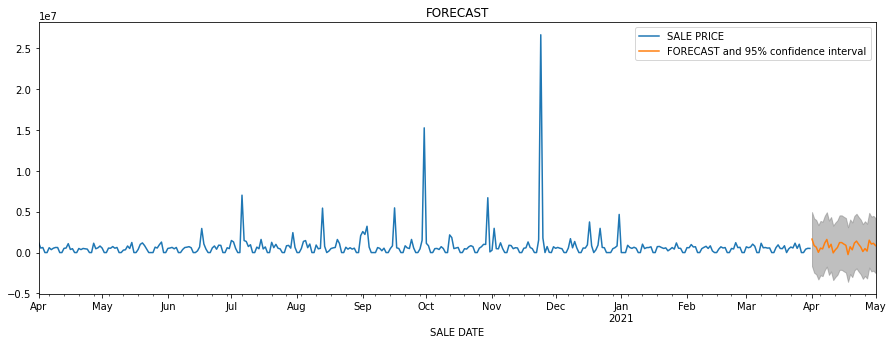

In [23]:
#plot of ARMA model
plt.figure(figsize=(20,10))
fig, ax = plt.subplots()
ax = df_price_date['SALE PRICE'].plot(ax=ax, title='FORECAST',figsize=(15,5))
fig = ar1.plot_predict(365, 395, dynamic=True, ax=ax, plot_insample=True)

handles, labels = ax.get_legend_handles_labels()
labels = ['SALE PRICE', 'FORECAST and 95% confidence interval']
ax.legend(handles, labels)

plt.show()

## 6a - Error Analysis of new model

Length of Predictions :  90
Length of Test data :  90
RMSE :  596832.8714853799
Standard Error :  nan


Text(0, 0.5, 'Average Price (in hundreds of thousands)')

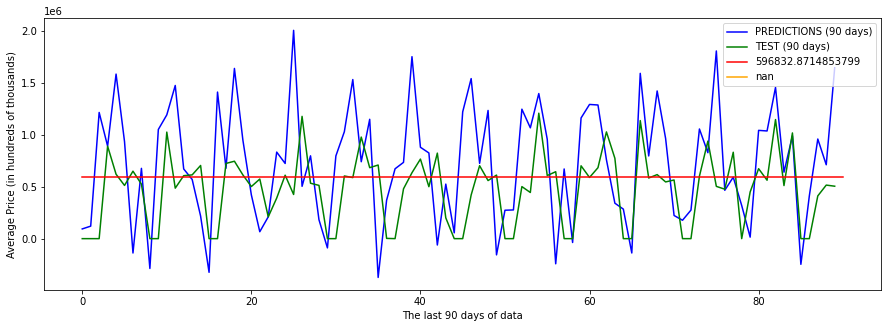

In [24]:
predictions = list(ar1.predict(276, 365))
test = list(df_price_date['SALE PRICE'][275:365])

print("\033[1m" + '\033[4m'+ 'Length of Predictions' + "\033[0m", ': ', len(predictions))
print("\033[1m" + '\033[4m'+ 'Length of Test data' + "\033[0m", ': ', len(test))

#RMSE
mse = sklearn.metrics.mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
print("\033[1m" + '\033[4m'+ 'RMSE' + "\033[0m", ': ', rmse)

#standard error
stderr = ar1.bse.const
print("\033[1m" + '\033[4m'+ 'Standard Error' + "\033[0m", ': ', stderr)

#plot of all
plt.figure(figsize=(15,5))
plt.plot(predictions, label='PREDICTIONS (90 days)', color='blue')
plt.plot(test, label='TEST (90 days)', color='green')

x=[0,90]
y=[rmse,rmse]
plt.plot(x,y, label=rmse, color='red')

x=[0,90]
y=[stderr,stderr]
plt.plot(x,y, label=stderr, color='orange')

plt.legend(loc='best')
plt.xlabel("The last 90 days of data")
plt.ylabel("Average Price (in hundreds of thousands)")

### Observation:

- Here RMSE is higher than original model. We will stick with original model.
- Getting nan for standard error, we will stick with origional model

## 7. Comparing predictions with fresh data from June 2021 dataset (4/1/2021 - 4/31/2021)

### Here I do the following:
1. Load data with only specific columns to borough
    - Sale price
    - Sale data
    - Borough
<br></br>
<br></br>
2. Clean the data to get rid of issues when plotting/calculating errors
    - This dataset was in .csv format, different from the origional rolling dataset
    - I had to filter the data and change columns from strings to int
    - Change 'SALE DATE' to datetime
    - Resample the data to match origional rolling data 
        - aggregate by day
<br></br> 
<br></br>
3. Plot the new data versus the predicted data and calculate RMSE

In [33]:
#Loading the data and reset the index

excel_df = pd.read_csv('NYC_Citywide_Rolling_Calendar_Sales.csv', usecols=['BOROUGH', 'SALE DATE', 'SALE PRICE'])
excel_df = excel_df[excel_df['BOROUGH']=='BRONX']
excel_df.reset_index(drop=True, inplace=True)

In [34]:
#Fixes to the data

excel_df['SALE PRICE'] = excel_df['SALE PRICE'].str.replace(',','')
excel_df['SALE PRICE'] = excel_df['SALE PRICE'].astype(int)
excel_df['SALE DATE'] = pd.to_datetime(excel_df['SALE DATE'])

In [35]:
#Create new dataframe and aggregate to days like I did with origional rolling data

excel_price_date = pd.DataFrame(excel_df, columns=['SALE DATE', 'SALE PRICE'])
excel_price_date = excel_price_date.set_index('SALE DATE')

#aggregate by day
excel_price_date = excel_price_date.resample('D').mean()

In [36]:
# Again, if I drop NaN here, it will change the dates which will affect the plotting
# I decide to fillna(0) similar to origional rolling data

excel_price_date = excel_price_date.fillna(0)

In [42]:
excel_price_date.head()

,SALE PRICE
SALE DATE,
2020-05-01,289617.647059
2020-05-02,0.000000
2020-05-03,0.000000
2020-05-04,151200.000000
2020-05-05,378428.571429


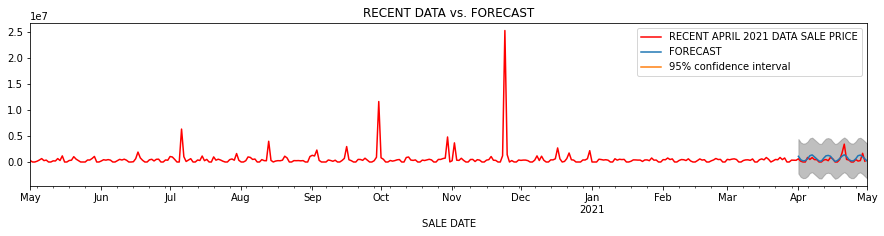

In [43]:
# Plotting the data versus the ar.plot_predict values

fig, ax = plt.subplots()

ax = excel_price_date['SALE PRICE'].plot(title='RECENT DATA vs. FORECAST', color='red')
fig = ar.plot_predict(365, 395, dynamic=True, ax = ax, plot_insample=True)

handles, labels = ax.get_legend_handles_labels()
labels = ['RECENT APRIL 2021 DATA SALE PRICE', 'FORECAST','95% confidence interval']
ax.legend(handles, labels)

plt.show()

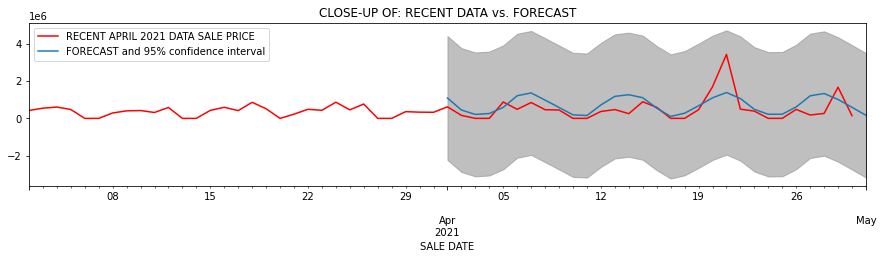

In [44]:
# Plotting the data versus the ar.plot_predict values
#Here I do a close up

fig, ax = plt.subplots()

ax = excel_price_date['SALE PRICE'][305:365].plot(title='CLOSE-UP OF: RECENT DATA vs. FORECAST', color='red')
fig = ar.plot_predict(365, 395, dynamic=True, ax = ax, plot_insample=True)

handles, labels = ax.get_legend_handles_labels()
labels = ['RECENT APRIL 2021 DATA SALE PRICE', 'FORECAST and 95% confidence interval']
ax.legend(handles, labels)

plt.show()

### Observation

- We see that the model looks like it fits well versus the test data of 4/1/2021 until 4/31/2021
- There is a spike in April 2021, probably a building got sold for millions
    - This will affect our RMSE

Length of Predictions :  30
Length of Test data :  30
RMSE :  613352.5983605037
Standard Error :  89789.23592683914


Text(0, 0.5, 'Average Price (in hundreds of thousands)')

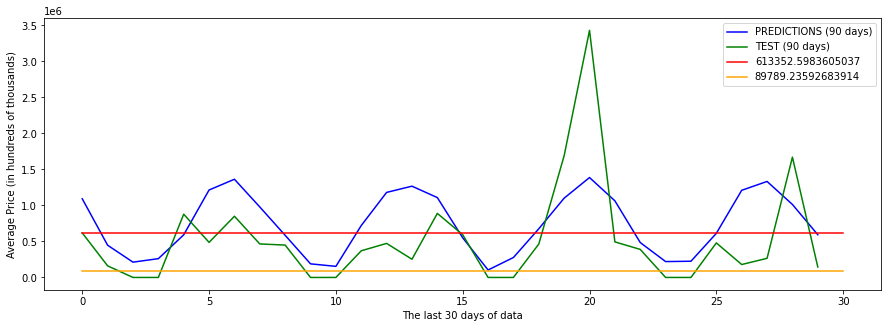

In [45]:
#RMSE, Standard error

# last 30 days of data
predictions = list(ar.predict(365, 394))
test = list(excel_price_date['SALE PRICE'][335:365])

print("\033[1m" + '\033[4m'+ 'Length of Predictions' + "\033[0m", ': ', len(predictions))
print("\033[1m" + '\033[4m'+ 'Length of Test data' + "\033[0m", ': ', len(test))

#RMSE
mse = sklearn.metrics.mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
print("\033[1m" + '\033[4m'+ 'RMSE' + "\033[0m", ': ', rmse)

#standard error
stderr = ar.bse.const
print("\033[1m" + '\033[4m'+ 'Standard Error' + "\033[0m", ': ', stderr)

#plot of all
plt.figure(figsize=(15,5))
plt.plot(predictions, label='PREDICTIONS (90 days)', color='blue')
plt.plot(test, label='TEST (90 days)', color='green')

x=[0,30]
y=[rmse,rmse]
plt.plot(x,y, label=rmse, color='red')

x=[0,30]
y=[stderr,stderr]
plt.plot(x,y, label=stderr, color='orange')

plt.legend(loc='best')
plt.xlabel("The last 30 days of data")
plt.ylabel("Average Price (in hundreds of thousands)")

### Observation

1. RMSE is higher because of the spike in sales

## 8. Observations/Conclusions/Recommendations

    1. The point of this analysis was to see if the borough was good to invest in
    2. Based on the model:
        - We can enter to buy or exit to sell based on when the market will do well
    3. The borough sales look predictable
        - There is predicable fluctuation in Bronx
    4. There are unpredictable building sales which are very large amounts in the millions to tens of millions
    5. We can look at the top 10 building permit heavy locations further